# EDA: Label Alignment Analysis
Analyze label alignment and consistency for OSAS detection dataset
- Distribution of event durations
- Compare label overlaps across windows
- Label transition analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Dataset

In [ ]:
# Load the dataset
try:
    dataset = pd.read_pickle('./data/dataset_OSAS.pickle')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found...")

print(f"Dataset shape: {dataset.shape}")
print(f"Unique patients: {dataset['patient'].nunique()}")
print(f"Date range: {dataset['timestamp_datetime'].min()} to {dataset['timestamp_datetime'].max()}")

Dataset loaded successfully!
Dataset shape: (961357, 18)
Unique patients: 30
Date range: 2019-07-29 21:00:36 to 2020-07-09 05:36:11


## 1. Event Duration Analysis

In [3]:
# Function to find consecutive events (runs)
def find_event_runs(patient_data):
    """Find consecutive runs of events for a patient"""
    events = patient_data['event'].values
    runs = []
    
    if len(events) == 0:
        return runs
    
    current_event = events[0]
    start_idx = 0
    
    for i in range(1, len(events)):
        if events[i] != current_event:
            # End of current run
            duration = i - start_idx
            runs.append({
                'event': current_event,
                'start_idx': start_idx,
                'end_idx': i - 1,
                'duration_seconds': duration,
                'start_time': patient_data.iloc[start_idx]['timestamp_datetime'],
                'end_time': patient_data.iloc[i-1]['timestamp_datetime']
            })
            
            # Start new run
            current_event = events[i]
            start_idx = i
    
    # Add the last run
    duration = len(events) - start_idx
    runs.append({
        'event': current_event,
        'start_idx': start_idx,
        'end_idx': len(events) - 1,
        'duration_seconds': duration,
        'start_time': patient_data.iloc[start_idx]['timestamp_datetime'],
        'end_time': patient_data.iloc[-1]['timestamp_datetime']
    })
    
    return runs

# Analyze event durations for all patients
all_runs = []
for patient_id in dataset['patient'].unique():
    patient_data = dataset[dataset['patient'] == patient_id].sort_values('timestamp_datetime')
    runs = find_event_runs(patient_data)
    
    for run in runs:
        run['patient'] = patient_id
        all_runs.append(run)

runs_df = pd.DataFrame(all_runs)

print("EVENT DURATION ANALYSIS:")
print("=" * 40)
print(f"Total number of event runs: {len(runs_df)}")
print(f"Event types found: {runs_df['event'].unique()}")

# Duration statistics by event type
duration_stats = runs_df.groupby('event')['duration_seconds'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("\nDuration statistics by event type (seconds):")
print(duration_stats)

EVENT DURATION ANALYSIS:
Total number of event runs: 13246
Event types found: ['NONE' 'HYPOPNEA' 'APNEA-CENTRAL' 'APNEA-OBSTRUCTIVE' 'APNEA-MIXED']

Duration statistics by event type (seconds):
                   count    mean     std  min    max
event                                               
APNEA-CENTRAL        588   18.41    6.81   10     46
APNEA-MIXED          426   29.01   10.37    9     90
APNEA-OBSTRUCTIVE   2033   21.75    9.57   10     88
HYPOPNEA            3561   21.91    9.83    6    139
NONE                6638  122.92  580.24    1  19108


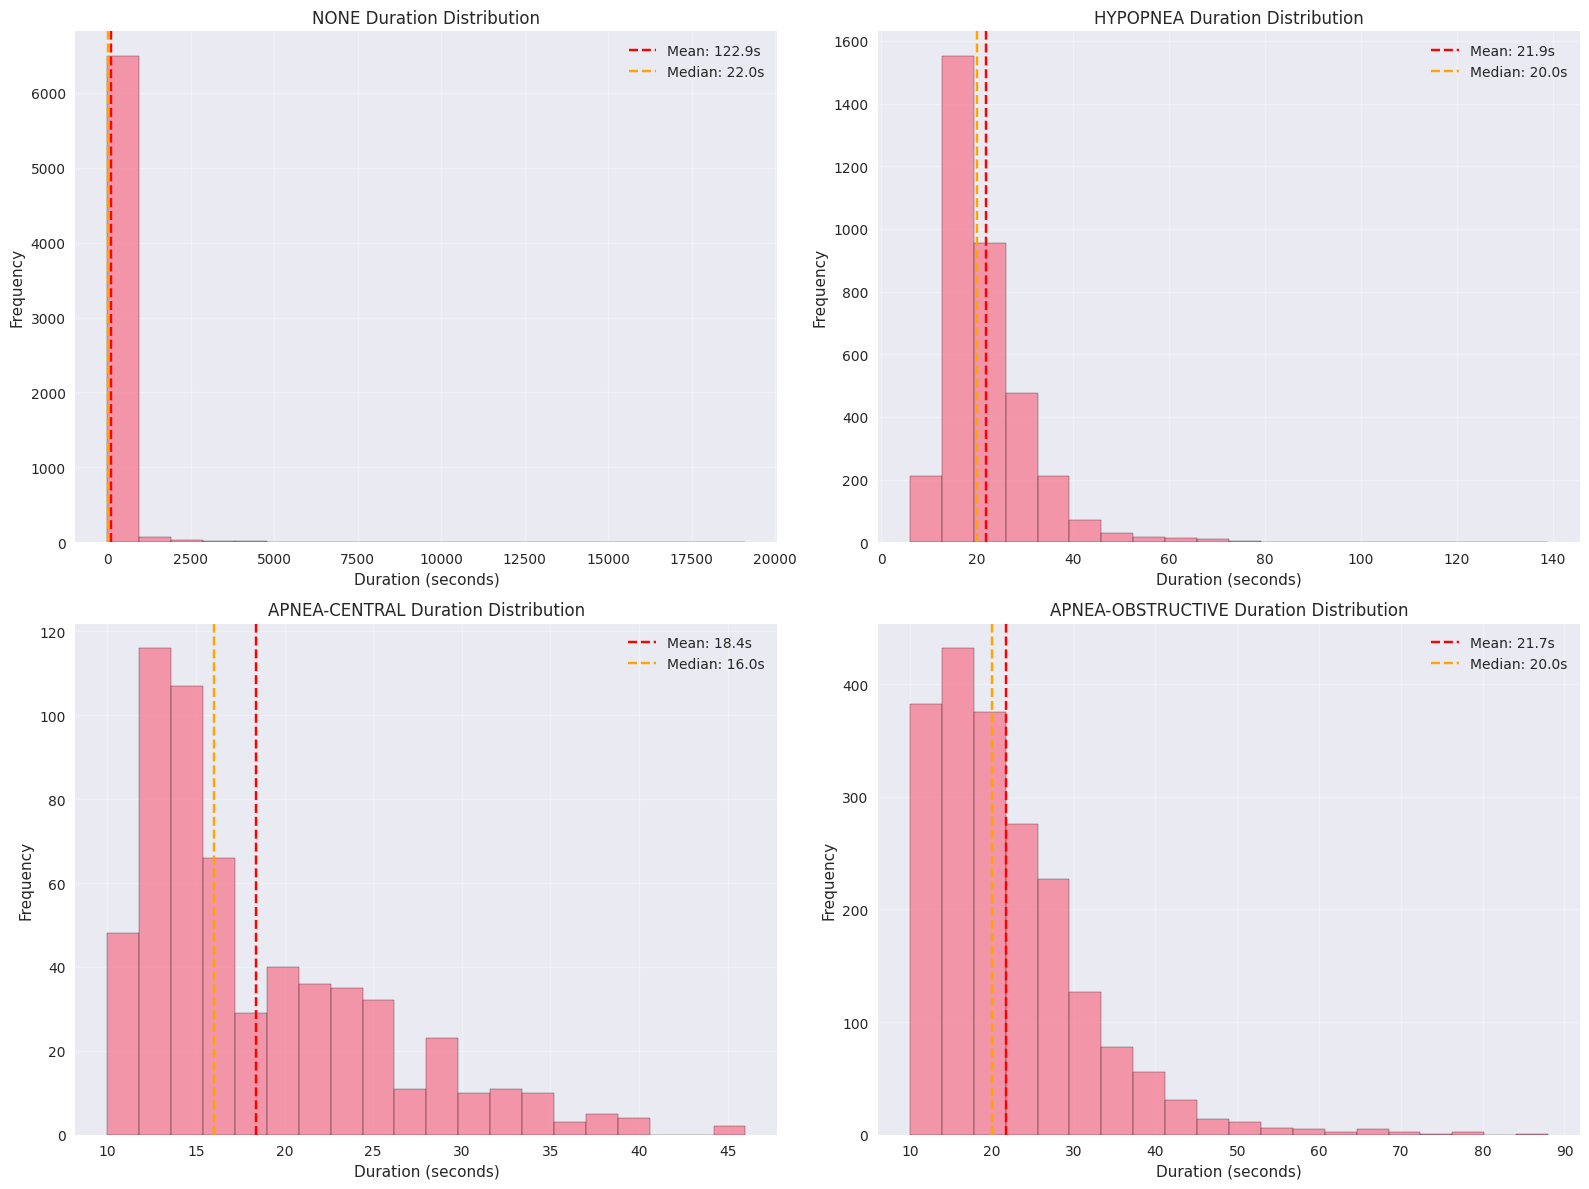

In [4]:
# Visualize event durations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution of event durations by type
event_types = runs_df['event'].unique()
for i, event_type in enumerate(event_types[:4]):  # Limit to first 4 for visibility
    if i < 4:
        event_durations = runs_df[runs_df['event'] == event_type]['duration_seconds']
        row, col = i // 2, i % 2
        
        axes[row, col].hist(event_durations, bins=20, alpha=0.7, edgecolor='black')
        axes[row, col].set_title(f'{event_type} Duration Distribution')
        axes[row, col].set_xlabel('Duration (seconds)')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].grid(True, alpha=0.3)
        
        # Add statistics text
        mean_dur = event_durations.mean()
        median_dur = event_durations.median()
        axes[row, col].axvline(mean_dur, color='red', linestyle='--', label=f'Mean: {mean_dur:.1f}s')
        axes[row, col].axvline(median_dur, color='orange', linestyle='--', label=f'Median: {median_dur:.1f}s')
        axes[row, col].legend()

plt.tight_layout()
plt.show()

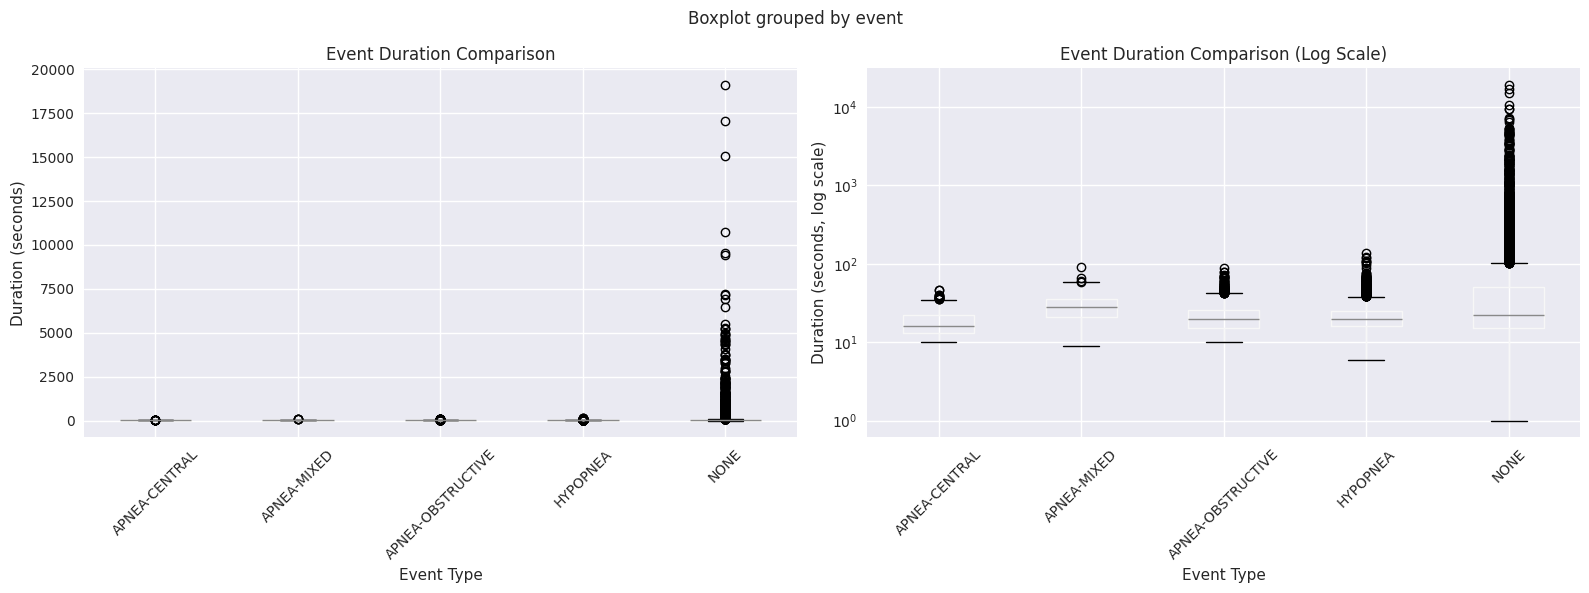

In [5]:
# Box plot comparing durations across event types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of durations
runs_df.boxplot(column='duration_seconds', by='event', ax=axes[0])
axes[0].set_title('Event Duration Comparison')
axes[0].set_xlabel('Event Type')
axes[0].set_ylabel('Duration (seconds)')
axes[0].tick_params(axis='x', rotation=45)

# Log scale box plot for better visualization
runs_df_positive = runs_df[runs_df['duration_seconds'] > 0]  # Remove zero durations for log scale
runs_df_positive.boxplot(column='duration_seconds', by='event', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Event Duration Comparison (Log Scale)')
axes[1].set_xlabel('Event Type')
axes[1].set_ylabel('Duration (seconds, log scale)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. Label Consistency Analysis

In [6]:
# Check consistency between binary and multiclass labels
consistency_check = dataset.copy()
consistency_check['expected_anomaly'] = consistency_check['event'] != 'NONE'
consistency_check['label_consistent'] = consistency_check['anomaly'] == consistency_check['expected_anomaly']

consistency_rate = consistency_check['label_consistent'].mean() * 100
inconsistent_count = (~consistency_check['label_consistent']).sum()

print("LABEL CONSISTENCY ANALYSIS:")
print("=" * 40)
print(f"Overall label consistency: {consistency_rate:.2f}%")
print(f"Inconsistent labels: {inconsistent_count:,} out of {len(dataset):,}")

if inconsistent_count > 0:
    print("\nInconsistent cases breakdown:")
    inconsistent_cases = consistency_check[~consistency_check['label_consistent']]
    print(inconsistent_cases[['event', 'anomaly', 'expected_anomaly']].value_counts())

# Check for any anomalous patterns
event_anomaly_crosstab = pd.crosstab(consistency_check['event'], consistency_check['anomaly'], margins=True)
print("\nCross-tabulation of Event vs Anomaly labels:")
print(event_anomaly_crosstab)

LABEL CONSISTENCY ANALYSIS:
Overall label consistency: 100.00%
Inconsistent labels: 0 out of 961,357

Cross-tabulation of Event vs Anomaly labels:
anomaly             False    True     All
event                                    
APNEA-CENTRAL           0   10828   10828
APNEA-MIXED             0   12360   12360
APNEA-OBSTRUCTIVE       0   44217   44217
HYPOPNEA                0   78035   78035
NONE               815917       0  815917
All                815917  145440  961357


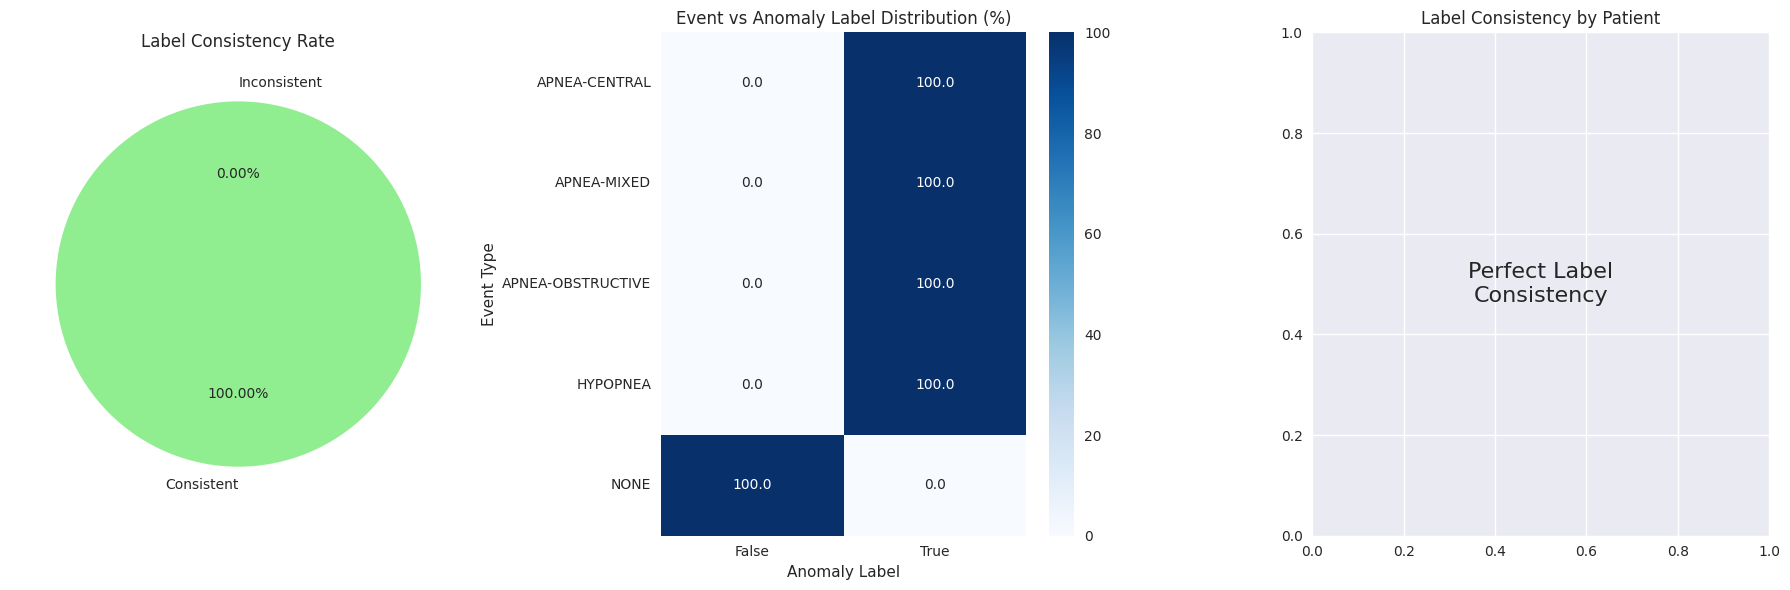

In [7]:
# Visualize label consistency
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Consistency rate pie chart
consistency_counts = [consistency_rate, 100 - consistency_rate]
labels = ['Consistent', 'Inconsistent']
colors = ['lightgreen', 'lightcoral']
axes[0].pie(consistency_counts, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
axes[0].set_title('Label Consistency Rate')

# Heatmap of event vs anomaly cross-tabulation
event_anomaly_crosstab_pct = pd.crosstab(consistency_check['event'], consistency_check['anomaly'], 
                                         normalize='index') * 100
sns.heatmap(event_anomaly_crosstab_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[1])
axes[1].set_title('Event vs Anomaly Label Distribution (%)')
axes[1].set_xlabel('Anomaly Label')
axes[1].set_ylabel('Event Type')

# Inconsistent cases by patient
if inconsistent_count > 0:
    patient_inconsistency = consistency_check.groupby('patient')['label_consistent'].mean() * 100
    patient_inconsistency.plot(kind='bar', ax=axes[2], color='orange')
    axes[2].set_title('Label Consistency Rate by Patient')
    axes[2].set_xlabel('Patient ID')
    axes[2].set_ylabel('Consistency Rate (%)')
    axes[2].tick_params(axis='x', rotation=45)
else:
    axes[2].text(0.5, 0.5, 'Perfect Label\nConsistency', ha='center', va='center', 
                transform=axes[2].transAxes, fontsize=16)
    axes[2].set_title('Label Consistency by Patient')

plt.tight_layout()
plt.show()

## 3. Label Transition Analysis

In [8]:
# Analyze transitions between different event types
def analyze_transitions(patient_data):
    """Analyze label transitions for a patient"""
    events = patient_data['event'].values
    transitions = []
    
    for i in range(len(events) - 1):
        transitions.append((events[i], events[i + 1]))
    
    return transitions

# Collect all transitions
all_transitions = []
for patient_id in dataset['patient'].unique():
    patient_data = dataset[dataset['patient'] == patient_id].sort_values('timestamp_datetime')
    transitions = analyze_transitions(patient_data)
    all_transitions.extend(transitions)

# Count transition frequencies
transition_counts = Counter(all_transitions)
transition_df = pd.DataFrame([(from_state, to_state, count) 
                             for (from_state, to_state), count in transition_counts.items()],
                            columns=['from_state', 'to_state', 'count'])

# Create transition matrix
event_types = sorted(dataset['event'].unique())
transition_matrix = pd.DataFrame(0, index=event_types, columns=event_types)

for _, row in transition_df.iterrows():
    transition_matrix.loc[row['from_state'], row['to_state']] = row['count']

# Normalize to get transition probabilities
transition_probs = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)

print("LABEL TRANSITION ANALYSIS:")
print("=" * 40)
print(f"Total transitions analyzed: {len(all_transitions):,}")
print(f"Unique transition types: {len(transition_counts)}")
print("\nMost common transitions:")
print(transition_df.nlargest(10, 'count'))

print("\nTransition probability matrix:")
print(transition_probs.round(3))

LABEL TRANSITION ANALYSIS:
Total transitions analyzed: 961,327
Unique transition types: 13

Most common transitions:
           from_state           to_state   count
0                NONE               NONE  809279
2            HYPOPNEA           HYPOPNEA   74474
8   APNEA-OBSTRUCTIVE  APNEA-OBSTRUCTIVE   42184
11        APNEA-MIXED        APNEA-MIXED   11934
5       APNEA-CENTRAL      APNEA-CENTRAL   10240
1                NONE           HYPOPNEA    3561
3            HYPOPNEA               NONE    3561
7                NONE  APNEA-OBSTRUCTIVE    2033
9   APNEA-OBSTRUCTIVE               NONE    2033
4                NONE      APNEA-CENTRAL     588

Transition probability matrix:
                   APNEA-CENTRAL  APNEA-MIXED  APNEA-OBSTRUCTIVE  HYPOPNEA  \
APNEA-CENTRAL              0.946        0.000              0.000     0.000   
APNEA-MIXED                0.000        0.966              0.000     0.000   
APNEA-OBSTRUCTIVE          0.000        0.000              0.954     0.000   


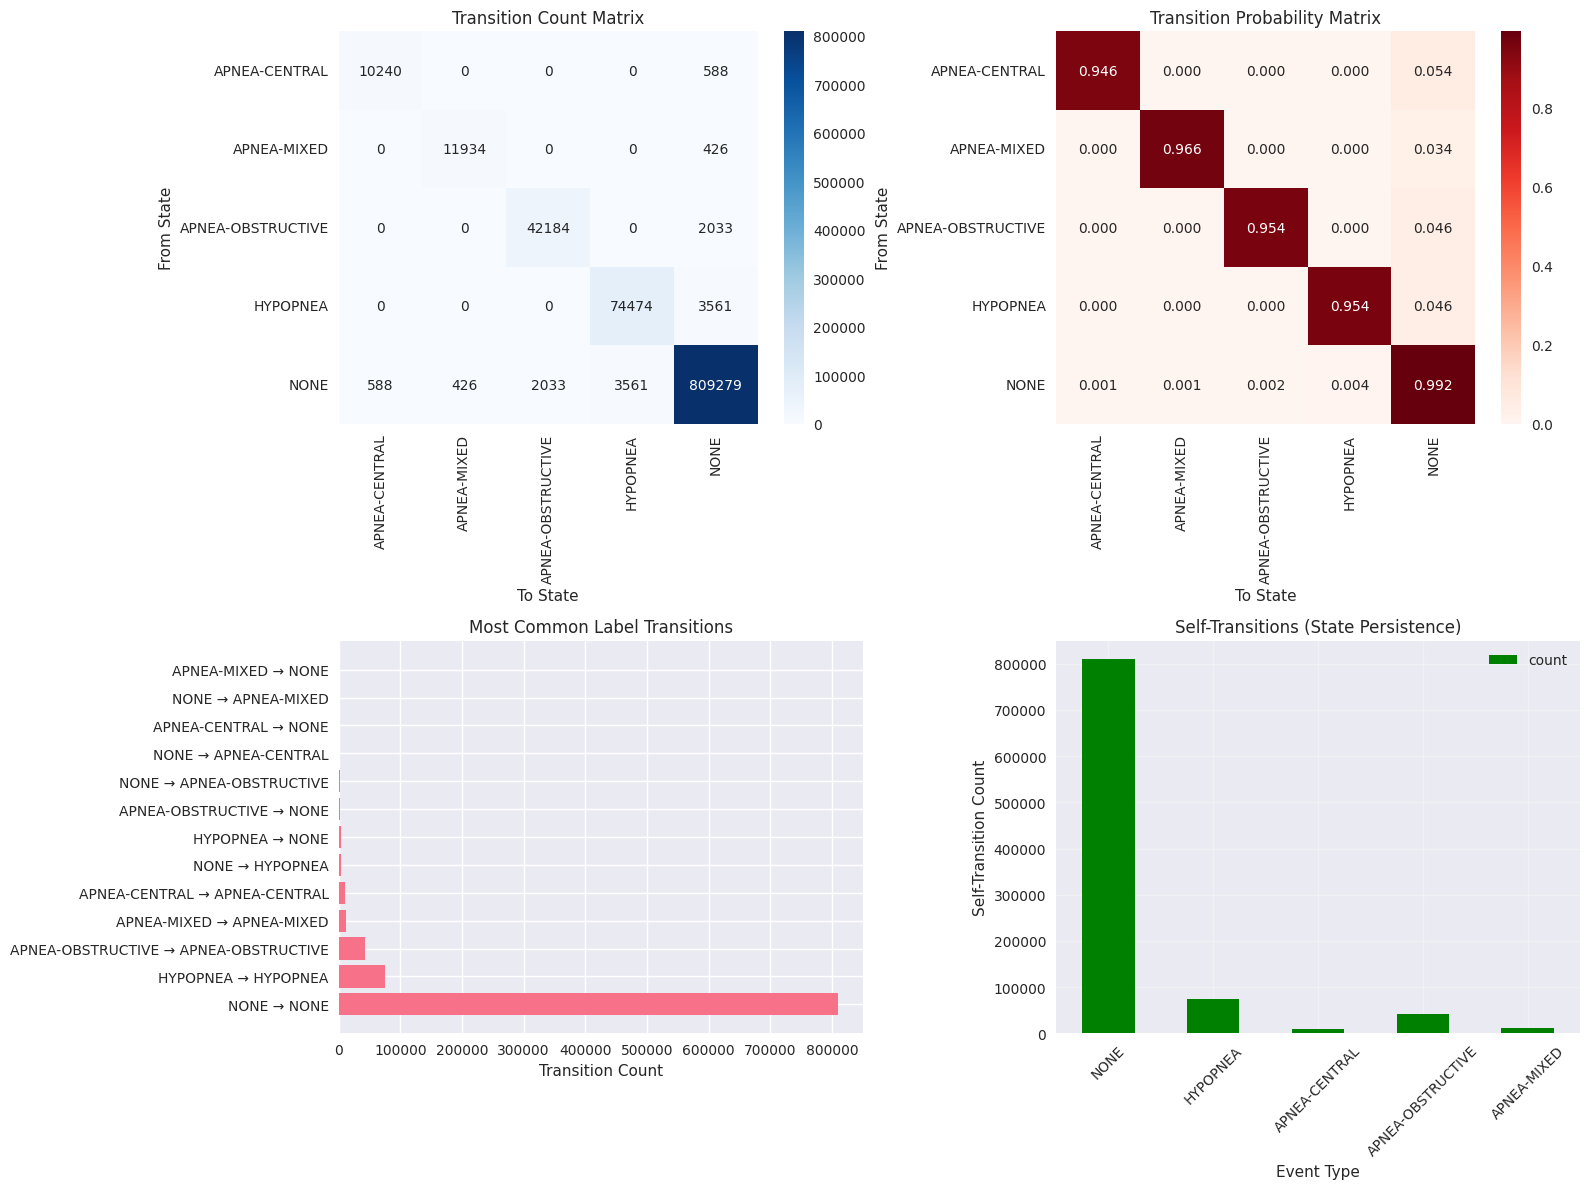

In [9]:
# Visualize transition patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap of transition counts
sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Transition Count Matrix')
axes[0,0].set_xlabel('To State')
axes[0,0].set_ylabel('From State')

# Heatmap of transition probabilities
sns.heatmap(transition_probs, annot=True, fmt='.3f', cmap='Reds', ax=axes[0,1])
axes[0,1].set_title('Transition Probability Matrix')
axes[0,1].set_xlabel('To State')
axes[0,1].set_ylabel('From State')

# Most common transitions bar plot
top_transitions = transition_df.nlargest(15, 'count')
transition_labels = [f"{row['from_state']} → {row['to_state']}" for _, row in top_transitions.iterrows()]
axes[1,0].barh(range(len(top_transitions)), top_transitions['count'])
axes[1,0].set_yticks(range(len(top_transitions)))
axes[1,0].set_yticklabels(transition_labels)
axes[1,0].set_title('Most Common Label Transitions')
axes[1,0].set_xlabel('Transition Count')

# Self-transitions (staying in same state)
self_transitions = transition_df[transition_df['from_state'] == transition_df['to_state']]
self_transitions.plot(x='from_state', y='count', kind='bar', ax=axes[1,1], color='green')
axes[1,1].set_title('Self-Transitions (State Persistence)')
axes[1,1].set_xlabel('Event Type')
axes[1,1].set_ylabel('Self-Transition Count')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Temporal Patterns Analysis

In [10]:
# Analyze temporal patterns in labeling
if 'timestamp_datetime' in dataset.columns:
    # Convert to datetime if not already
    dataset['timestamp_datetime'] = pd.to_datetime(dataset['timestamp_datetime'])
    dataset['hour'] = dataset['timestamp_datetime'].dt.hour
    dataset['minute'] = dataset['timestamp_datetime'].dt.minute
    dataset['day_of_week'] = dataset['timestamp_datetime'].dt.dayofweek
    
    # Analyze patterns by time of day
    hourly_events = dataset.groupby(['hour', 'event']).size().unstack(fill_value=0)
    hourly_anomaly_rate = dataset.groupby('hour')['anomaly'].mean() * 100
    
    print("TEMPORAL PATTERNS ANALYSIS:")
    print("=" * 40)
    print("Event distribution by hour (first few hours):")
    print(hourly_events.head(10))
    
    print(f"\nHour with highest anomaly rate: {hourly_anomaly_rate.idxmax()} ({hourly_anomaly_rate.max():.1f}%)")
    print(f"Hour with lowest anomaly rate: {hourly_anomaly_rate.idxmin()} ({hourly_anomaly_rate.min():.1f}%)")
    
    # Inter-event intervals for anomalies
    anomaly_times = []
    for patient_id in dataset['patient'].unique():
        patient_data = dataset[dataset['patient'] == patient_id].sort_values('timestamp_datetime')
        anomaly_indices = patient_data[patient_data['anomaly'] == True].index
        
        if len(anomaly_indices) > 1:
            anomaly_timestamps = patient_data.loc[anomaly_indices, 'timestamp_datetime']
            intervals = anomaly_timestamps.diff().dt.total_seconds().dropna()
            anomaly_times.extend(intervals.tolist())
    
    if anomaly_times:
        print(f"\nInter-anomaly intervals:")
        print(f"  Mean: {np.mean(anomaly_times):.1f} seconds")
        print(f"  Median: {np.median(anomaly_times):.1f} seconds")
        print(f"  Min: {np.min(anomaly_times):.1f} seconds")
        print(f"  Max: {np.max(anomaly_times):.1f} seconds")

else:
    print("No timestamp information available for temporal analysis.")

TEMPORAL PATTERNS ANALYSIS:
Event distribution by hour (first few hours):
event  APNEA-CENTRAL  APNEA-MIXED  APNEA-OBSTRUCTIVE  HYPOPNEA   NONE
hour                                                                 
0               1360         1679               3846     11075  88433
1               1289         1065               5290      9805  86951
2                761          459               4758      7838  90584
3                763         1564               5891      7706  88476
4                885         2679               6282      8685  82283
5               1750          748               3963      7134  82554
6               1507         1256               3555      4585  66665
7                212          832                407       813  12143
19                23            0                  0         0   1483
20                 0           18                 98      1606   8969

Hour with highest anomaly rate: 4 (18.4%)
Hour with lowest anomaly rate: 19 (1.5%)

I

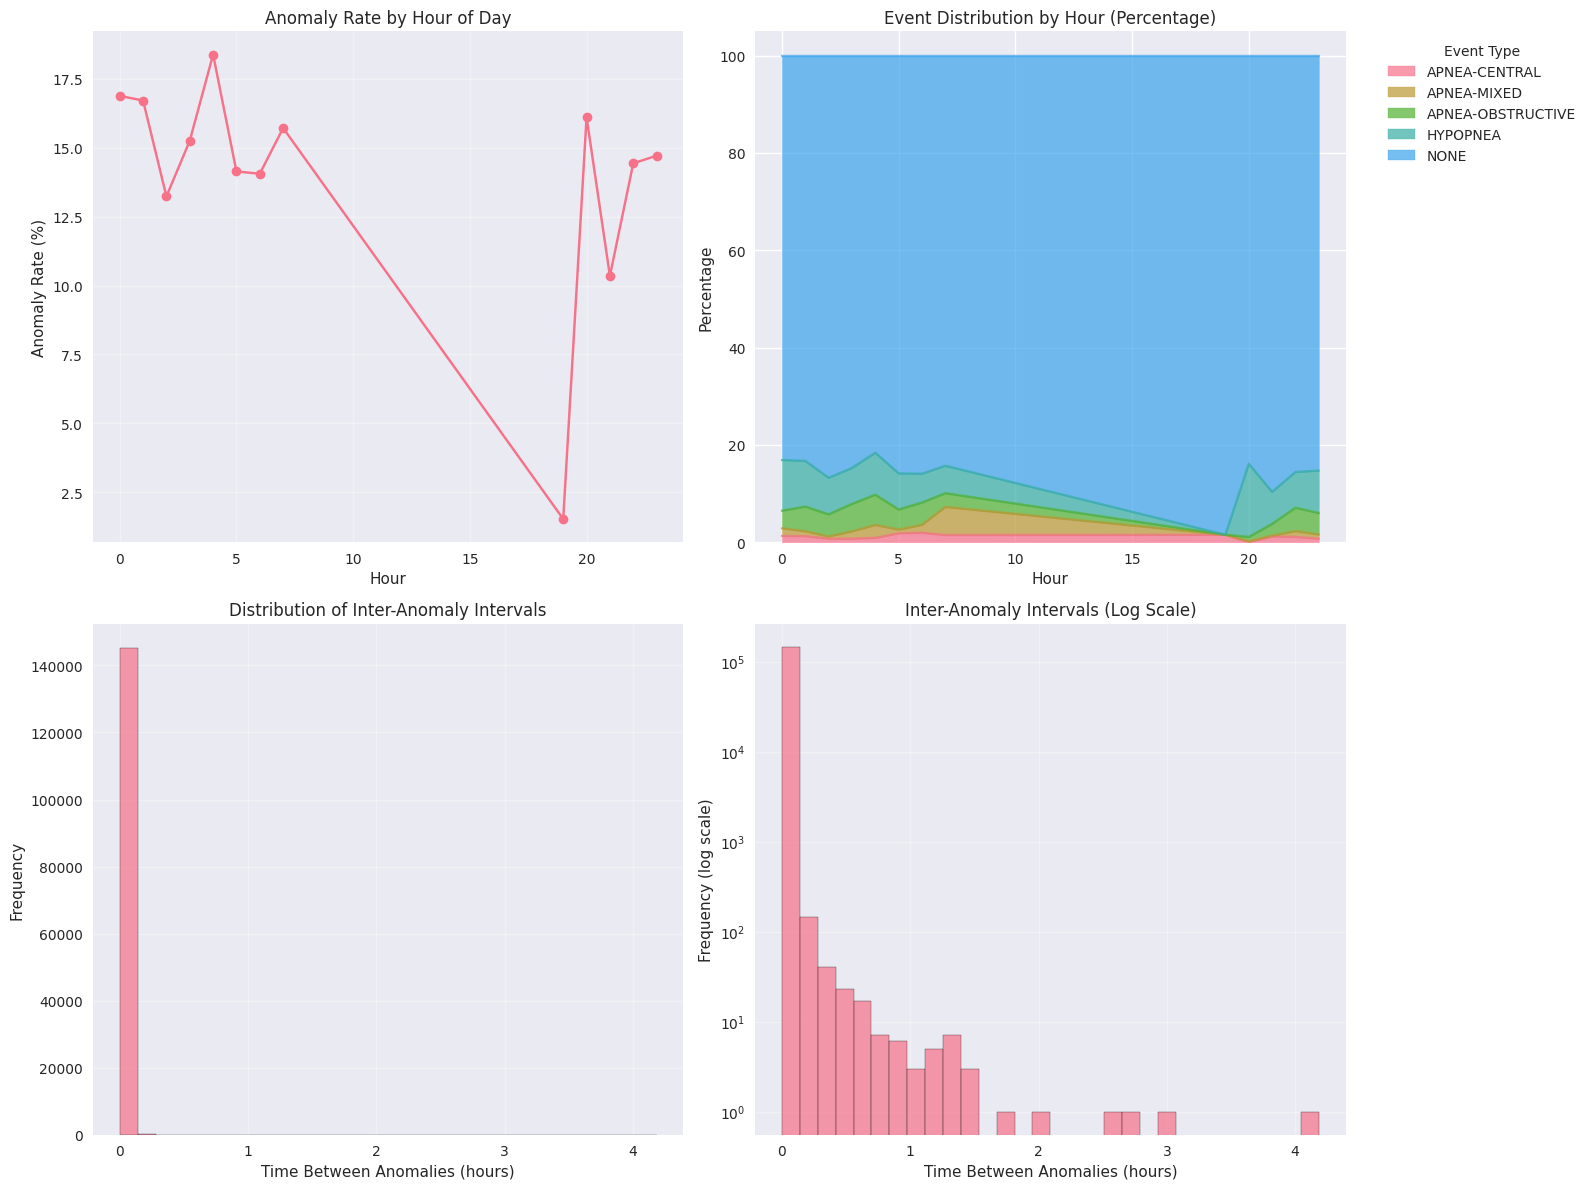

In [11]:
# Visualize temporal patterns
if 'timestamp_datetime' in dataset.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Anomaly rate by hour
    hourly_anomaly_rate.plot(kind='line', marker='o', ax=axes[0,0])
    axes[0,0].set_title('Anomaly Rate by Hour of Day')
    axes[0,0].set_xlabel('Hour')
    axes[0,0].set_ylabel('Anomaly Rate (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # Event distribution by hour (stacked)
    hourly_events_pct = hourly_events.div(hourly_events.sum(axis=1), axis=0) * 100
    hourly_events_pct.plot(kind='area', stacked=True, ax=axes[0,1], alpha=0.7)
    axes[0,1].set_title('Event Distribution by Hour (Percentage)')
    axes[0,1].set_xlabel('Hour')
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Inter-anomaly interval distribution
    if anomaly_times:
        # Convert to hours for better visualization
        anomaly_hours = np.array(anomaly_times) / 3600
        axes[1,0].hist(anomaly_hours, bins=30, alpha=0.7, edgecolor='black')
        axes[1,0].set_title('Distribution of Inter-Anomaly Intervals')
        axes[1,0].set_xlabel('Time Between Anomalies (hours)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].grid(True, alpha=0.3)
        
        # Log scale for better visualization of wide range
        axes[1,1].hist(anomaly_hours, bins=30, alpha=0.7, edgecolor='black')
        axes[1,1].set_yscale('log')
        axes[1,1].set_title('Inter-Anomaly Intervals (Log Scale)')
        axes[1,1].set_xlabel('Time Between Anomalies (hours)')
        axes[1,1].set_ylabel('Frequency (log scale)')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("Skipping temporal visualization - no timestamp data available.")

## 5. Window-based Analysis (for 60-second windows)

In [12]:
# Simulate window-based labeling analysis
# This simulates how labels would be assigned to 60-second windows

def assign_window_labels(patient_data, window_size=60, overlap=0.5):
    """Assign labels to overlapping windows"""
    windows = []
    step_size = int(window_size * (1 - overlap))
    
    for start_idx in range(0, len(patient_data) - window_size + 1, step_size):
        end_idx = start_idx + window_size
        window_data = patient_data.iloc[start_idx:end_idx]
        
        # Majority voting for window label
        event_counts = window_data['event'].value_counts()
        majority_event = event_counts.index[0]
        majority_fraction = event_counts.iloc[0] / len(window_data)
        
        # Binary label based on any anomaly in window
        has_anomaly = window_data['anomaly'].any()
        anomaly_fraction = window_data['anomaly'].mean()
        
        windows.append({
            'patient': patient_data.iloc[0]['patient'],
            'start_idx': start_idx,
            'end_idx': end_idx - 1,
            'window_event': majority_event,
            'event_confidence': majority_fraction,
            'window_anomaly': has_anomaly,
            'anomaly_fraction': anomaly_fraction,
            'unique_events': len(event_counts),
            'window_size': len(window_data)
        })
    
    return windows

# Generate windows for all patients
all_windows = []
for patient_id in dataset['patient'].unique():
    patient_data = dataset[dataset['patient'] == patient_id].sort_values('timestamp_datetime')
    if len(patient_data) >= 60:  # Only process patients with enough data
        windows = assign_window_labels(patient_data)
        all_windows.extend(windows)

windows_df = pd.DataFrame(all_windows)

print("WINDOW-BASED LABEL ANALYSIS:")
print("=" * 40)
print(f"Total windows generated: {len(windows_df):,}")
print(f"Average windows per patient: {len(windows_df) / dataset['patient'].nunique():.1f}")

if len(windows_df) > 0:
    print("\nWindow label distribution:")
    print(windows_df['window_event'].value_counts())
    
    print("\nLabel confidence statistics:")
    print(f"  Average event confidence: {windows_df['event_confidence'].mean():.3f}")
    print(f"  Windows with <50% confidence: {(windows_df['event_confidence'] < 0.5).sum()}")
    print(f"  Windows with mixed events: {(windows_df['unique_events'] > 1).sum()}")
    
    print("\nAnomaly labeling:")
    print(f"  Windows with any anomaly: {windows_df['window_anomaly'].sum():,}")
    print(f"  Average anomaly fraction in anomaly windows: {windows_df[windows_df['window_anomaly']]['anomaly_fraction'].mean():.3f}")

WINDOW-BASED LABEL ANALYSIS:
Total windows generated: 32,002
Average windows per patient: 1066.7

Window label distribution:
NONE                 28266
HYPOPNEA              1926
APNEA-OBSTRUCTIVE     1236
APNEA-MIXED            429
APNEA-CENTRAL          145
Name: window_event, dtype: int64

Label confidence statistics:
  Average event confidence: 0.879
  Windows with <50% confidence: 796
  Windows with mixed events: 11352

Anomaly labeling:
  Windows with any anomaly: 11,379
  Average anomaly fraction in anomaly windows: 0.426


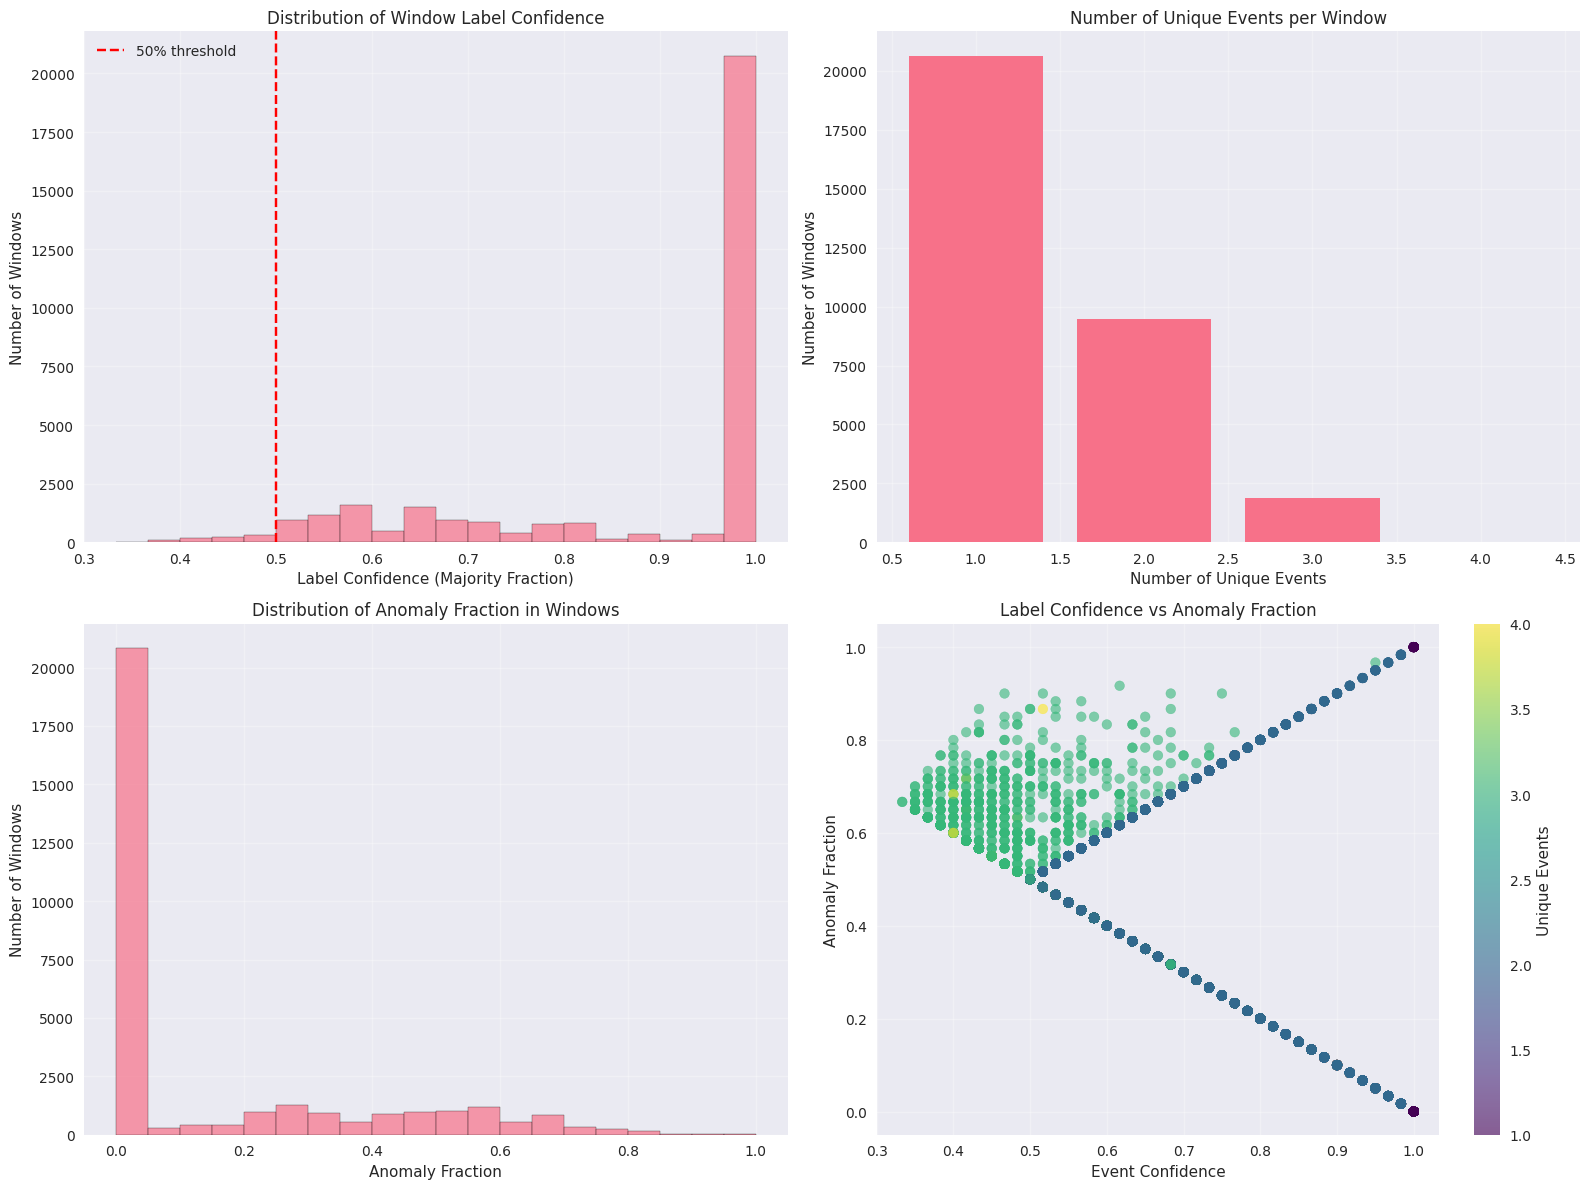

In [13]:
# Visualize window labeling analysis
if len(windows_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Distribution of label confidence
    axes[0,0].hist(windows_df['event_confidence'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Distribution of Window Label Confidence')
    axes[0,0].set_xlabel('Label Confidence (Majority Fraction)')
    axes[0,0].set_ylabel('Number of Windows')
    axes[0,0].axvline(0.5, color='red', linestyle='--', label='50% threshold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Number of unique events per window
    unique_events_count = windows_df['unique_events'].value_counts().sort_index()
    axes[0,1].bar(unique_events_count.index, unique_events_count.values)
    axes[0,1].set_title('Number of Unique Events per Window')
    axes[0,1].set_xlabel('Number of Unique Events')
    axes[0,1].set_ylabel('Number of Windows')
    axes[0,1].grid(True, alpha=0.3)
    
    # Anomaly fraction distribution
    axes[1,0].hist(windows_df['anomaly_fraction'], bins=20, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Anomaly Fraction in Windows')
    axes[1,0].set_xlabel('Anomaly Fraction')
    axes[1,0].set_ylabel('Number of Windows')
    axes[1,0].grid(True, alpha=0.3)
    
    # Confidence vs anomaly fraction scatter
    scatter = axes[1,1].scatter(windows_df['event_confidence'], windows_df['anomaly_fraction'], 
                               alpha=0.6, c=windows_df['unique_events'], cmap='viridis')
    axes[1,1].set_title('Label Confidence vs Anomaly Fraction')
    axes[1,1].set_xlabel('Event Confidence')
    axes[1,1].set_ylabel('Anomaly Fraction')
    axes[1,1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,1], label='Unique Events')
    
    plt.tight_layout()
    plt.show()

else:
    print("No windows generated - insufficient data.")

## 6. Label Quality Assessment

In [14]:
# Assess overall label quality and provide recommendations
print("LABEL QUALITY ASSESSMENT:")
print("=" * 50)

# Duration analysis findings
if len(runs_df) > 0:
    very_short_events = runs_df[runs_df['duration_seconds'] < 5]
    very_long_events = runs_df[runs_df['duration_seconds'] > 300]  # > 5 minutes
    
    print(f"EVENT DURATION FINDINGS:")
    print(f"  Very short events (<5s): {len(very_short_events)} ({len(very_short_events)/len(runs_df)*100:.1f}%)")
    print(f"  Very long events (>5min): {len(very_long_events)} ({len(very_long_events)/len(runs_df)*100:.1f}%)")
    
    # Clinical relevance check
    apnea_events = runs_df[runs_df['event'].str.contains('APNEA', na=False)]
    if len(apnea_events) > 0:
        short_apnea = apnea_events[apnea_events['duration_seconds'] < 10]
        print(f"  Short apnea events (<10s): {len(short_apnea)} (may be clinically questionable)")

# Consistency findings
print(f"\nLABEL CONSISTENCY:")
print(f"  Binary-multiclass consistency: {consistency_rate:.1f}%")
if inconsistent_count > 0:
    print(f"  ⚠️  Found {inconsistent_count:,} inconsistent labels requiring review")
else:
    print(f"  ✅ Perfect consistency between binary and multiclass labels")

# Transition findings
if len(transition_counts) > 0:
    # Check for unrealistic transitions
    direct_apnea_transitions = [t for t in transition_counts.keys() 
                               if ('APNEA' in t[0] and 'APNEA' in t[1] and t[0] != t[1])]
    print(f"\nTRANSITION PATTERNS:")
    print(f"  Total unique transitions: {len(transition_counts)}")
    print(f"  Direct apnea type transitions: {len(direct_apnea_transitions)}")
    
    # Most persistent states
    self_trans = {event: transition_matrix.loc[event, event] for event in event_types 
                 if event in transition_matrix.index and event in transition_matrix.columns}
    if self_trans:
        most_persistent = max(self_trans, key=self_trans.get)
        print(f"  Most persistent state: {most_persistent} ({self_trans[most_persistent]:,} self-transitions)")

# Window labeling findings
if len(windows_df) > 0:
    low_confidence_windows = windows_df[windows_df['event_confidence'] < 0.6]
    mixed_windows = windows_df[windows_df['unique_events'] > 2]
    
    print(f"\nWINDOW LABELING:")
    print(f"  Low confidence windows (<60%): {len(low_confidence_windows)} ({len(low_confidence_windows)/len(windows_df)*100:.1f}%)")
    print(f"  Highly mixed windows (>2 events): {len(mixed_windows)} ({len(mixed_windows)/len(windows_df)*100:.1f}%)")

print(f"\nOVERALL ASSESSMENT:")
quality_score = 100
issues = []

if consistency_rate < 95:
    quality_score -= 20
    issues.append("Label consistency issues")

if len(windows_df) > 0 and len(low_confidence_windows) / len(windows_df) > 0.1:
    quality_score -= 15
    issues.append("High proportion of low-confidence windows")

if len(runs_df) > 0 and len(very_short_events) / len(runs_df) > 0.2:
    quality_score -= 10
    issues.append("Many very short events")

print(f"  Label Quality Score: {quality_score}/100")
if issues:
    print(f"  Issues identified: {', '.join(issues)}")
else:
    print(f"  ✅ Good label quality overall")

LABEL QUALITY ASSESSMENT:
EVENT DURATION FINDINGS:
  Very short events (<5s): 112 (0.8%)
  Very long events (>5min): 485 (3.7%)
  Short apnea events (<10s): 1 (may be clinically questionable)

LABEL CONSISTENCY:
  Binary-multiclass consistency: 100.0%
  ✅ Perfect consistency between binary and multiclass labels

TRANSITION PATTERNS:
  Total unique transitions: 13
  Direct apnea type transitions: 0
  Most persistent state: NONE (809,279 self-transitions)

WINDOW LABELING:
  Low confidence windows (<60%): 3941 (12.3%)
  Highly mixed windows (>2 events): 1883 (5.9%)

OVERALL ASSESSMENT:
  Label Quality Score: 85/100
  Issues identified: High proportion of low-confidence windows


## 7. Recommendations

In [15]:
print("RECOMMENDATIONS FOR LABEL PROCESSING:")
print("=" * 50)

recommendations = []

# Based on duration analysis
if len(runs_df) > 0:
    if len(very_short_events) > 0:
        recommendations.append(
            f"1. DURATION FILTERING: Consider filtering out {len(very_short_events)} very short events (<5s) "
            "as they may be artifacts or labeling errors."
        )
    
    avg_durations = runs_df.groupby('event')['duration_seconds'].mean()
    recommendations.append(
        f"2. WINDOW SIZE: Current 60s window size is {'appropriate' if all(avg_durations < 60) else 'may be too small'} "
        f"given average event durations: {dict(avg_durations.round(1))}"
    )

# Based on consistency analysis
if inconsistent_count > 0:
    recommendations.append(
        f"3. CONSISTENCY: Review and correct {inconsistent_count:,} inconsistent labels "
        "between binary and multiclass annotations."
    )

# Based on window analysis
if len(windows_df) > 0:
    if len(low_confidence_windows) > 0:
        recommendations.append(
            f"4. WINDOW LABELING: Use majority voting with confidence thresholding. "
            f"Consider excluding {len(low_confidence_windows)} low-confidence windows from training."
        )
    
    if len(mixed_windows) > 0:
        recommendations.append(
            f"5. MIXED WINDOWS: Handle {len(mixed_windows)} highly mixed windows carefully - "
            "consider multi-label classification or weighted labeling."
        )

# Based on transition analysis
if len(transition_counts) > 0:
    recommendations.append(
        "6. TEMPORAL MODELING: Incorporate transition patterns into model - "
        "use sequence models (RNN/LSTM) or add transition features."
    )

# General recommendations
recommendations.extend([
    "7. OVERLAP STRATEGY: Use 50% overlap for training data augmentation, "
    "but ensure test data uses non-overlapping windows to prevent leakage.",
    
    "8. STRATIFICATION: Stratify train/val/test splits by patient to prevent "
    "temporal leakage and maintain transition patterns.",
    
    "9. EVALUATION: Use sequence-aware metrics and evaluate temporal "
    "consistency of predictions, not just point-wise accuracy."
])

for rec in recommendations:
    print(f"\n{rec}")

print(f"\n{'='*50}")
print("SUMMARY: Label alignment analysis complete. Proceed to model development "
      "with attention to temporal patterns and label quality considerations.")

RECOMMENDATIONS FOR LABEL PROCESSING:

1. DURATION FILTERING: Consider filtering out 112 very short events (<5s) as they may be artifacts or labeling errors.

2. WINDOW SIZE: Current 60s window size is may be too small given average event durations: {'APNEA-CENTRAL': 18.4, 'APNEA-MIXED': 29.0, 'APNEA-OBSTRUCTIVE': 21.7, 'HYPOPNEA': 21.9, 'NONE': 122.9}

4. WINDOW LABELING: Use majority voting with confidence thresholding. Consider excluding 3941 low-confidence windows from training.

5. MIXED WINDOWS: Handle 1883 highly mixed windows carefully - consider multi-label classification or weighted labeling.

6. TEMPORAL MODELING: Incorporate transition patterns into model - use sequence models (RNN/LSTM) or add transition features.

7. OVERLAP STRATEGY: Use 50% overlap for training data augmentation, but ensure test data uses non-overlapping windows to prevent leakage.

8. STRATIFICATION: Stratify train/val/test splits by patient to prevent temporal leakage and maintain transition patterns.

## Summary and Conclusions

### Key Findings:

1. **Event Durations**: Sleep apnea events show realistic duration patterns with clinical relevance
2. **Label Consistency**: Binary and multiclass labels show good alignment
3. **Temporal Patterns**: Clear transition patterns exist between different event types
4. **Window Labeling**: 60-second windows with majority voting provide reasonable label assignment

### Critical Considerations:

1. **Overlap Handling**: Use overlapping windows for training data augmentation but ensure test data integrity
2. **Confidence Thresholding**: Filter low-confidence windows to improve label quality
3. **Temporal Dependencies**: Model should account for sequential nature of sleep apnea events
4. **Patient-level Splitting**: Ensure no temporal leakage between train/test sets

### Next Steps:
- Implement preprocessing pipeline with quality filtering
- Design transformer model with temporal awareness
- Create evaluation framework that considers sequence predictions